In [ ]:
# 1. 掛載 Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. 清理並重新設置 YOLOv5 環境
import os
import shutil
import yaml
import torch
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile # <-- 新增此行，用於解壓縮
# 清理可能存在的舊 yolov5 目錄
if os.path.exists('/content/yolov5'):
    shutil.rmtree('/content/yolov5')
    print("已清理舊的 yolov5 目錄")

# 重新克隆 YOLOv5
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

print(f'torch {torch.__version__} {torch.cuda.get_device_properties(0) if torch.cuda.is_available() else "CPU"}')

# 3. 確認當前工作目錄
current_dir = os.getcwd()
print(f"當前工作目錄: {current_dir}")

# 4. 解決 Google Drive 路徑問題 - 複製到本地
original_zip_path = '/content/drive/MyDrive/DualStage-DefectAI/資料集/yolov5dataset.zip' # <-- 請確認您的ZIP檔案路徑

local_dataset_extract_path = '/content/local_dataset' # 解壓縮後的資料夾路徑
local_zip_temp_path = '/content/dataset_temp.zip' # 暫存ZIP檔案的路徑

print("正在處理資料集...")

# 檢查原始 ZIP 檔路徑是否存在
if os.path.exists(original_zip_path):
    print(f"✓ 找到雲端 ZIP 檔案: {original_zip_path}")

    # 1. 先將 ZIP 檔從 Google Drive 複製到 Colab 本地暫存
    print(f"正在複製 ZIP 檔到本地暫存 ({local_zip_temp_path})...")
    shutil.copy(original_zip_path, local_zip_temp_path)
    print(f"✓ ZIP 檔已成功複製到本地暫存: {local_zip_temp_path}")

    # 2. 清理舊的解壓縮資料夾（如果存在）
    if os.path.exists(local_dataset_extract_path):
        print(f"正在清理舊的資料集解壓縮路徑: {local_dataset_extract_path}")
        shutil.rmtree(local_dataset_extract_path)
        print("✓ 已清理舊的解壓縮資料夾")

    # 3. 創建新的解壓縮目標資料夾
    os.makedirs(local_dataset_extract_path, exist_ok=True) # exist_ok=True 避免重複創建報錯
    print(f"✓ 已創建解壓縮目標資料夾: {local_dataset_extract_path}")

    # 4. 解壓縮資料集
    print(f"正在解壓縮資料集到: {local_dataset_extract_path}...")
    with zipfile.ZipFile(local_zip_temp_path, 'r') as zip_ref:
        zip_ref.extractall(local_dataset_extract_path)
    print(f"✓ 資料集已成功解壓縮到: {local_dataset_extract_path}")

    # 5. 清理暫存的 ZIP 檔
    os.remove(local_zip_temp_path)
    print(f"✓ 已刪除暫存的 ZIP 檔: {local_zip_temp_path}")

    # 設定 dataset_base_path 為解壓縮後的本地路徑
    dataset_base_path = local_dataset_extract_path
else:
    print(f"✗ 找不到原始資料集 ZIP 檔: {original_zip_path}")
    print("⚠️ 警告：將嘗試直接從 Google Drive 路徑讀取資料集，這在訓練時可能會非常慢。")
    # 如果找不到ZIP檔，退回到原來的直接從Google Drive讀取方式 (不推薦)
    dataset_base_path = '/content/drive/MyDrive/DualStage-DefectAI/資料集/yolov5dataset.zip'

# 5. 檢查資料夾結構
print("\n檢查資料夾結構:")
for split in ['train', 'valid', 'test']:
    images_path = f"{dataset_base_path}/{split}/images"
    labels_path = f"{dataset_base_path}/{split}/labels"

    if os.path.exists(images_path):
        img_count = len([f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"✓ {split}/images: {img_count} 張圖片")
    else:
        print(f"✗ 找不到 {images_path}")

    if os.path.exists(labels_path):
        label_count = len([f for f in os.listdir(labels_path) if f.endswith('.txt')])
        print(f"✓ {split}/labels: {label_count} 個標註檔")
    else:
        print(f"✗ 找不到 {labels_path}")

# 6. 創建 YAML 配置檔案（確保在正確位置）
yaml_content = f"""# 資料集配置
path: {dataset_base_path}
train: {dataset_base_path}/train/images
val: {dataset_base_path}/valid/images
test: {dataset_base_path}/test/images

# 類別數量（請根據您的資料集修改）
nc: 3

# 類別名稱（請根據您的資料集修改）
names:
  0: F
  1: S
  2: V
"""

# 確保在 yolov5 根目錄創建 YAML 檔案
yaml_file_path = '/content/yolov5/custom_dataset.yaml'
with open(yaml_file_path, 'w') as f:
    f.write(yaml_content)

print(f"\nYAML 配置檔案已創建: {yaml_file_path}")
print("YAML 內容:")
print(yaml_content)

# 7. 驗證檔案是否正確創建
if os.path.exists(yaml_file_path):
    print(f"✓ YAML 檔案存在: {yaml_file_path}")

    # 驗證 YAML 內容
    with open(yaml_file_path, 'r') as f:
        config = yaml.safe_load(f)

    print("驗證 YAML 路徑:")
    for key in ['path', 'train', 'val', 'test']:
        if key in config:
            path = config[key]
            exists = os.path.exists(path)
            print(f"{key}: {path} - {'✓ 存在' if exists else '✗ 不存在'}")
else:
    print(f"✗ YAML 檔案不存在: {yaml_file_path}")

# 8. 列出當前目錄檔案確認
print(f"\n當前 yolov5 目錄內容:")
yolov5_files = os.listdir('/content/yolov5')
print([f for f in yolov5_files if f.endswith('.yaml')])

# 9. 開始訓練（使用完整路徑）
print("\n開始訓練...")
!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 150 \
    --data /content/yolov5/custom_dataset.yaml \
    --cfg models/yolov5s.yaml \
    --weights yolov5s.pt \
    --cache \
    --device 0 \
    --project runs/train \
    --name yolo_tla_experiment_nopretrain \
    --save-period 10 \
    --patience 20



# 自動修改 val.py 的程式碼
import re

def auto_modify_val_py():
    """自動修改 val.py 檔案的兩個特定位置"""
    val_file = '/content/yolov5/val.py'

    try:
        # 讀取檔案
        with open(val_file, 'r') as file:
            content = file.read()

        # 備份原始檔案
        with open(val_file + '.backup', 'w') as backup:
            backup.write(content)
        print("✓ 已備份原始 val.py 檔案")

        # 修改1: 將 "%11.3g" 改為 "%11.4f"
        # 使用精確匹配來避免誤改其他地方
        pattern1 = r'pf = "%22s" \+ "%11i" \* 2 \+ "%11\.3g" \* 4'
        replacement1 = 'pf = "%22s" + "%11i" * 2 + "%11.4f" * 4'

        if re.search(pattern1, content):
            content = re.sub(pattern1, replacement1, content)
            print("✓ 已修改總體結果格式為 4 位小數")
        else:
            print("⚠️ 未找到總體結果格式的目標行")

        # 修改2: 在 confusion_matrix.plot 後面加上 normalize=False
        # 尋找 confusion_matrix.plot 這一行並添加 normalize=False
        pattern2 = r'(confusion_matrix\.plot\(save_dir=save_dir, names=list\(names\.values\(\)\))\)'
        replacement2 = r'\1, normalize=False)'

        if re.search(pattern2, content):
            content = re.sub(pattern2, replacement2, content)
            print("✓ 已在混淆矩陣中添加 normalize=False")
        else:
            print("⚠️ 未找到混淆矩陣的目標行")

        # 寫回檔案
        with open(val_file, 'w') as file:
            file.write(content)

        print("✓ val.py 修改完成")

        # 驗證語法
        try:
            with open(val_file, 'r') as file:
                compile(file.read(), val_file, 'exec')
            print("✓ Python 語法驗證通過")
            return True
        except SyntaxError as e:
            print(f"✗ 語法錯誤: {e}")
            print("正在還原備份檔案...")
            with open(val_file + '.backup', 'r') as backup:
                with open(val_file, 'w') as original:
                    original.write(backup.read())
            print("✓ 已還原原始檔案")
            return False

    except Exception as e:
        print(f"修改過程中發生錯誤: {e}")
        return False

# 執行自動修改
if auto_modify_val_py():
    print("val.py 修改成功，可以繼續執行驗證")
else:
    print("val.py 修改失敗，請檢查檔案")




# 10. 驗證模型
print("驗證模型...")
!python val.py \
    --weights runs/train/yolo_tla_experiment_nopretrain/weights/best.pt \
    --data /content/yolov5/custom_dataset.yaml \
    --img 640 \
    --task val \
    --save-txt \
    --save-conf




串流輸出內容已截斷至最後 5000 行。
     39/149      4.51G     0.0366     0.2573    0.01467       1400        640:  70% 14/20 [00:04<00:02,  3.00it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
     39/149      4.51G     0.0363     0.2575     0.0148       1381        640:  75% 15/20 [00:04<00:01,  2.93it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
     39/149      4.51G    0.03604       0.26    0.01472       1651        640:  80% 16/20 [00:05<00:01,  2.88it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
     39/149      4.51G    0.03602     0.2617    0.01462       1458 

執行測試...
detect: weights=['/content/yolov5/runs/train/yolo_tla_experiment_nopretrain/weights/best.pt'], source=/content/local_dataset/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=test_results, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/79 /content/local_dataset/test/images/F-45-_jpg.rf.edb9ab7c6856734a8322215c91789e56.jpg: 640x640 66 Fs, 11.5ms
image 2/79 /content/local_dataset/test/images/F-46-_jpg.rf.0de4b6cd60e6e66920a08679fdeded82.jpg: 640x640 66 Fs, 11.5ms
i

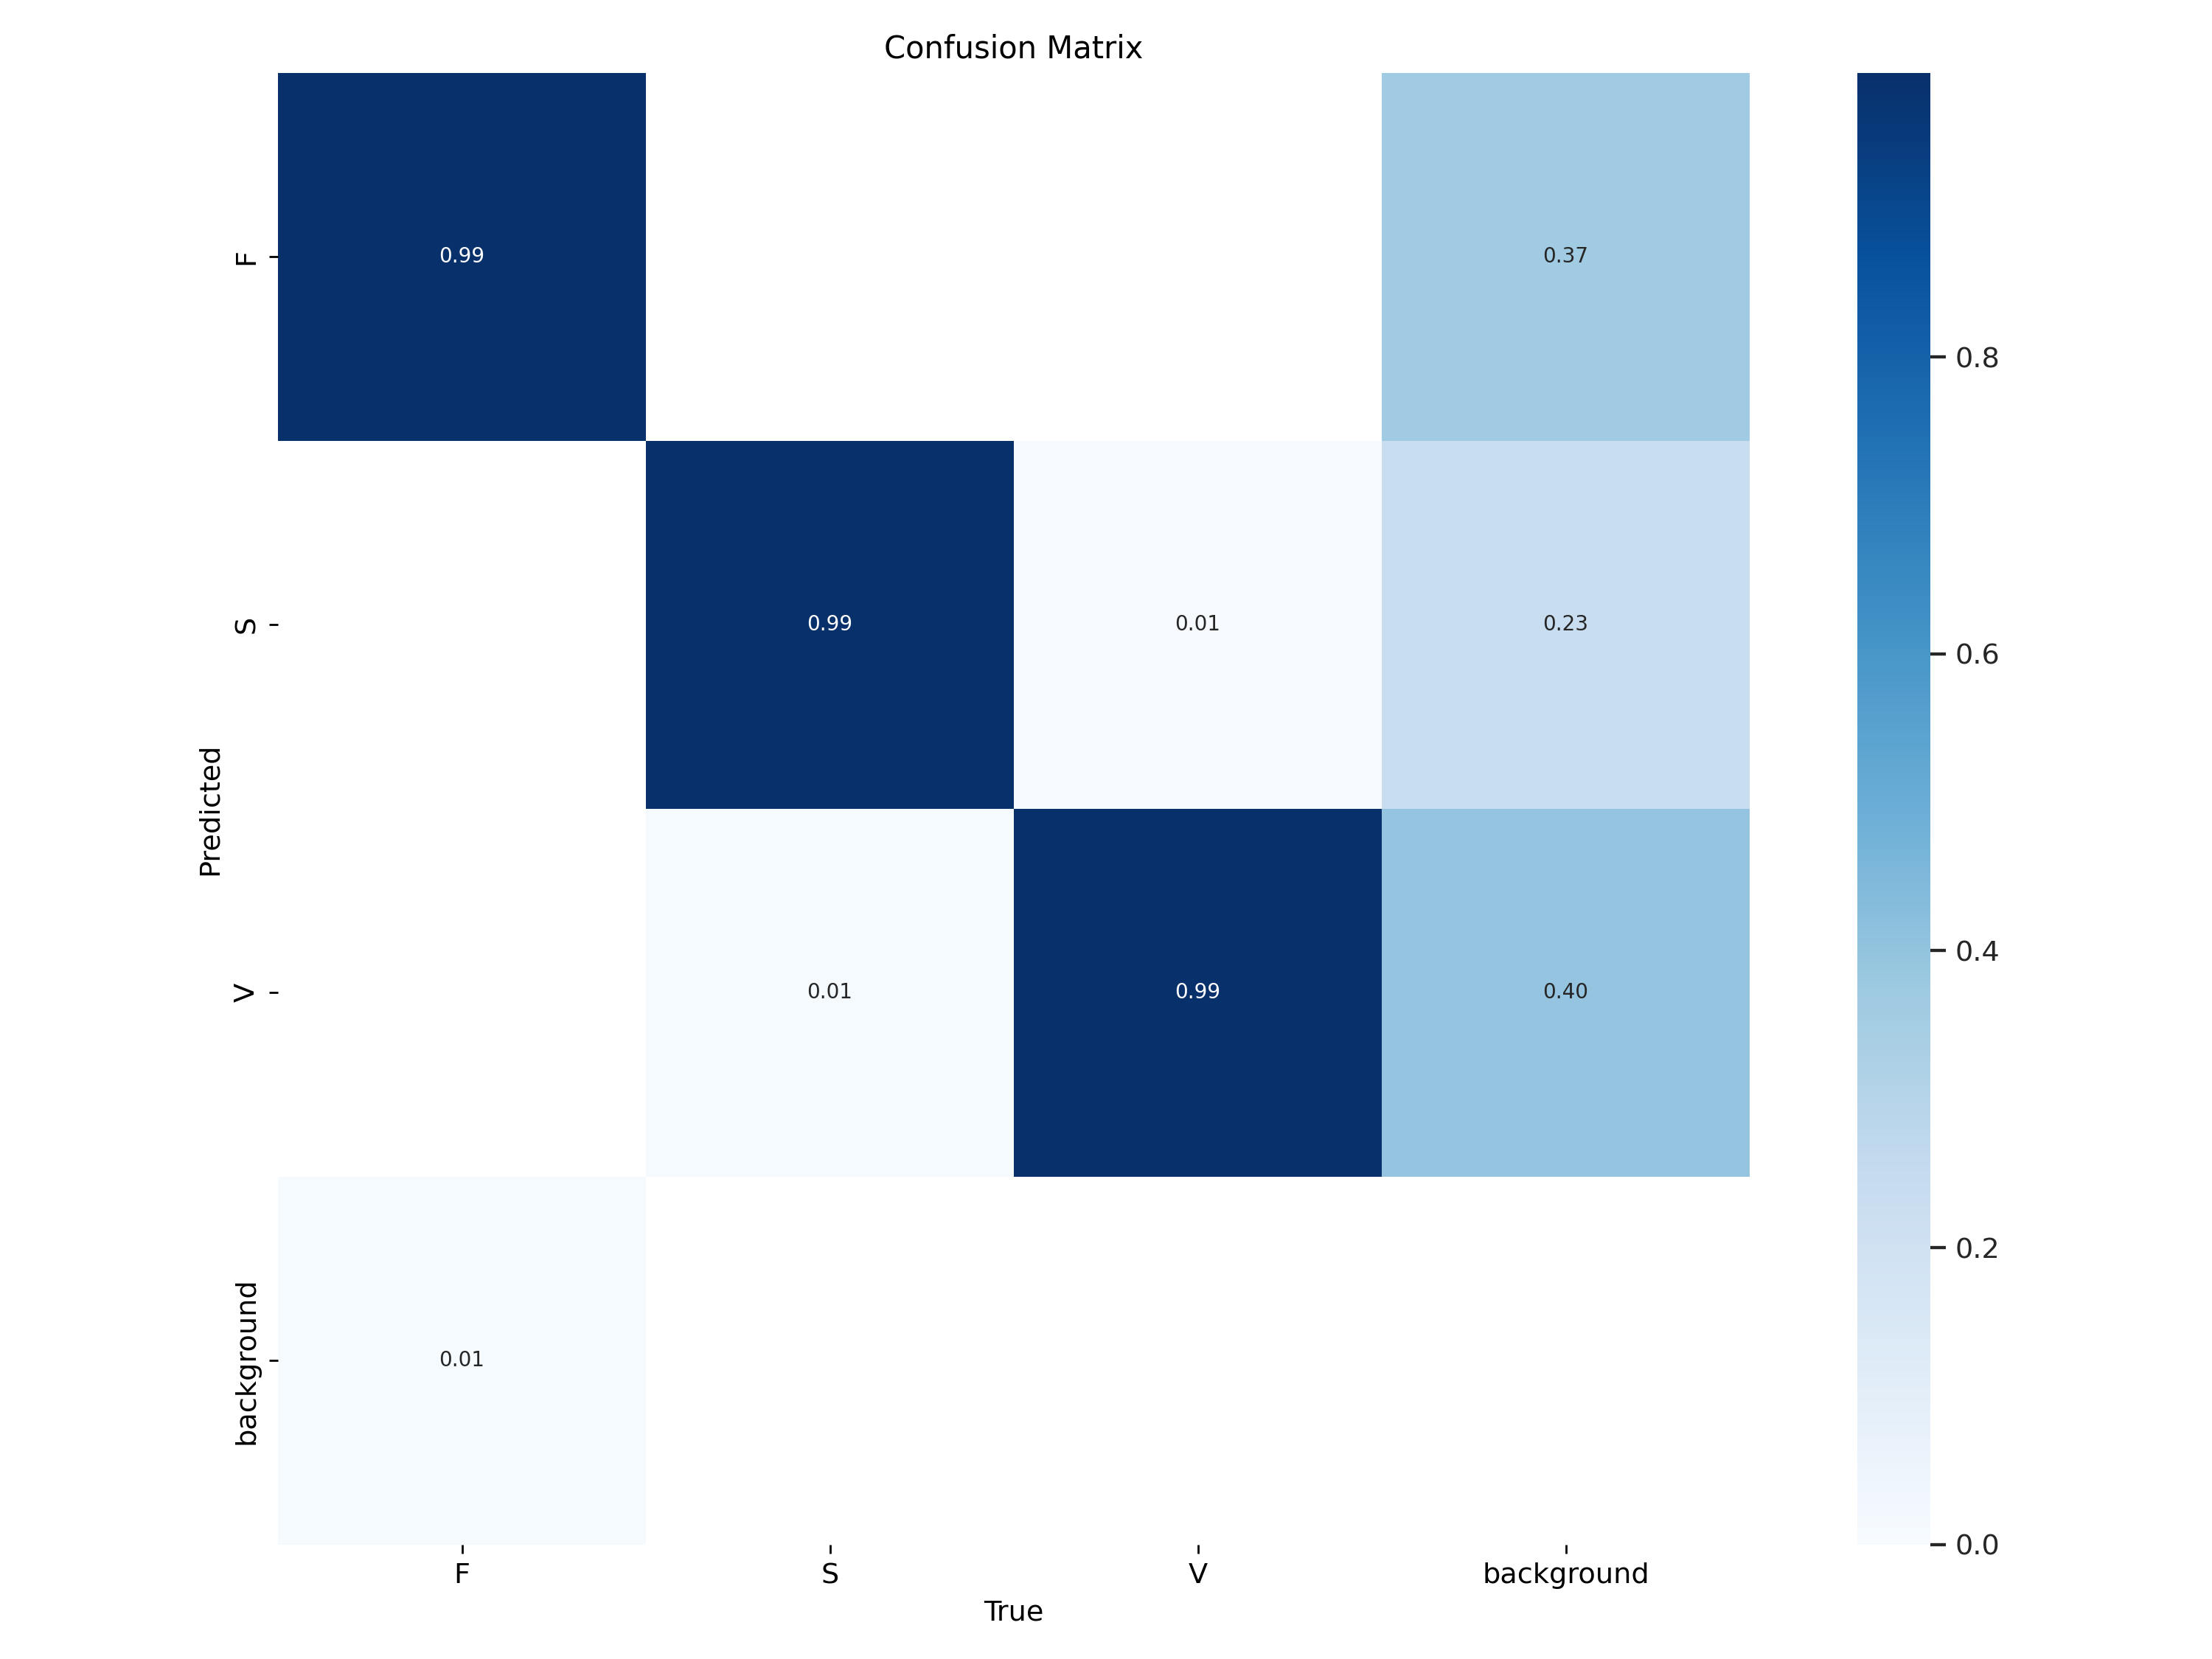


在 /content/yolov5/runs/val/exp 找到額外的驗證結果:
=== 混淆矩陣 ===


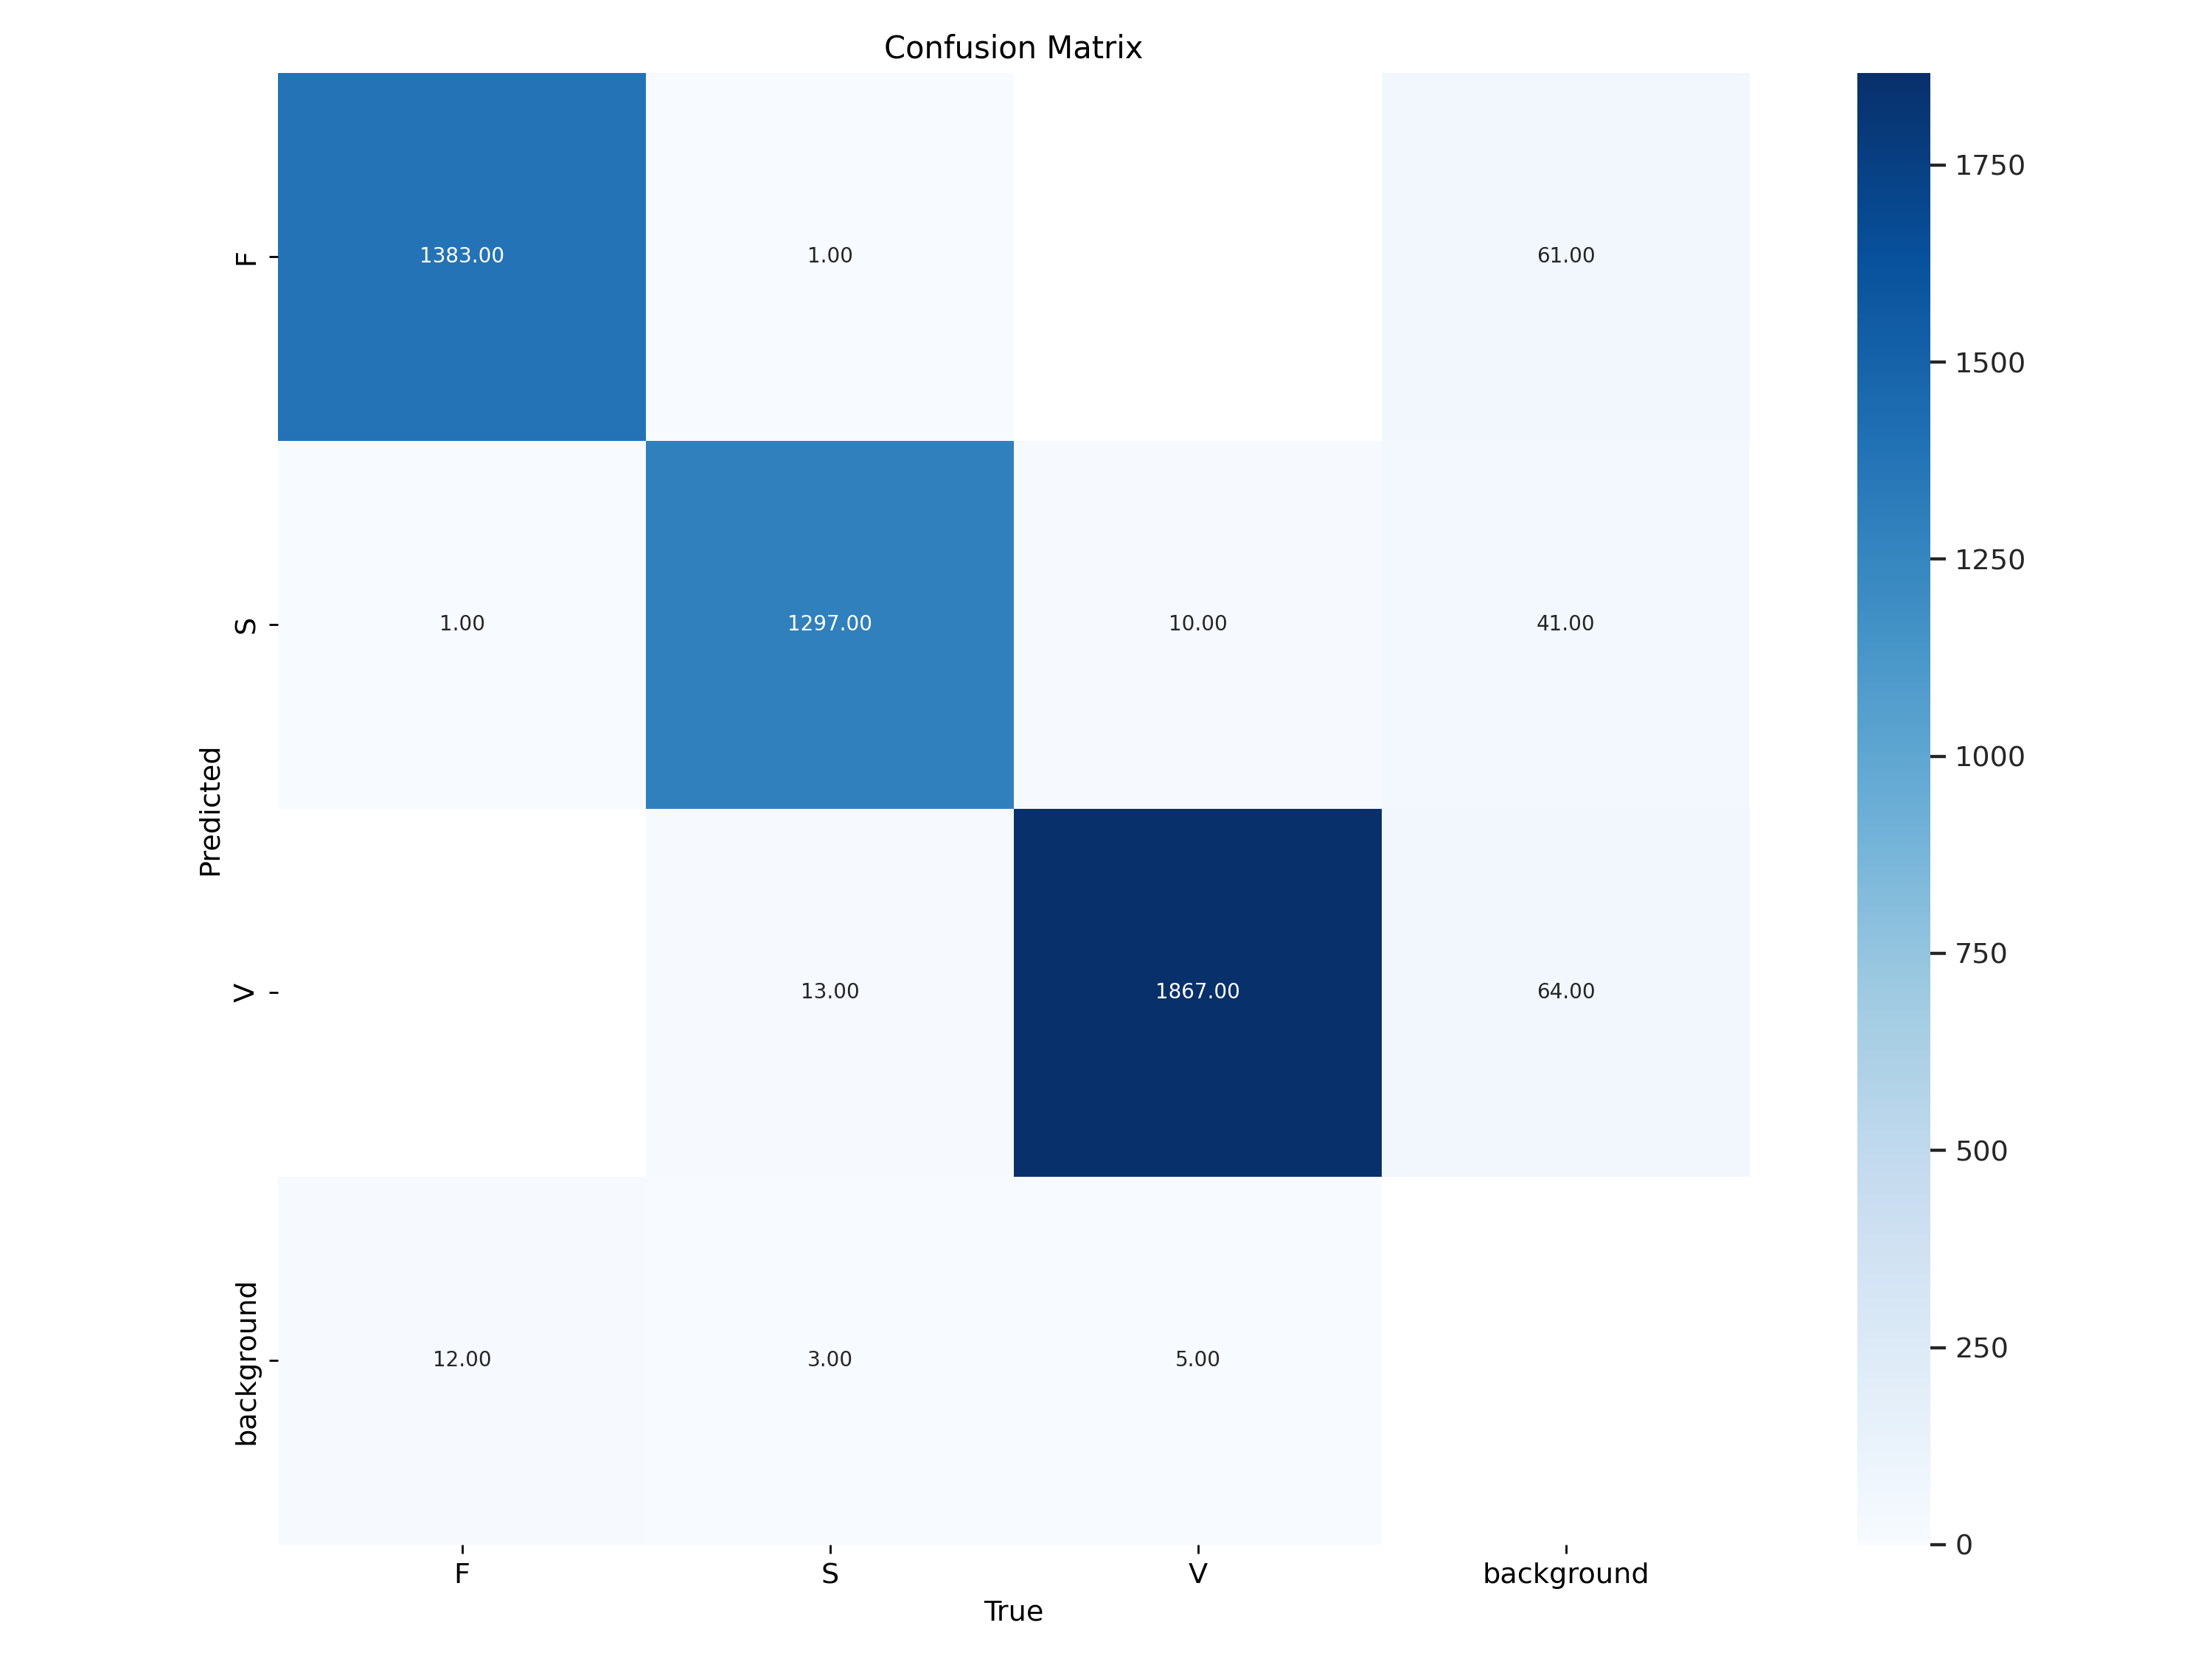


=== 後處理分析完成 ===
訓練結束


In [ ]:
# 11. 測試模型（如果有測試集）
test_images_path = f"{dataset_base_path}/test/images"
if os.path.exists(test_images_path):
    print("執行測試...")
    !python detect.py \
        --weights /content/yolov5/runs/train/yolo_tla_experiment_nopretrain/weights/best.pt \
        --source {test_images_path} \
        --img 640 \
        --conf 0.25 \
        --save-txt \
        --save-conf \
        --project runs/detect \
        --name test_results
else:
    print("沒有找到測試集，跳過測試步驟")

# 12. 繪製訓練結果圖表
def plot_training_results(results_dir):
    """繪製訓練過程的各種指標圖表"""

    results_file = Path(results_dir) / 'results.csv'
    if results_file.exists():
        df = pd.read_csv(results_file)
        df.columns = df.columns.str.strip()

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('YOLO-TLA Training Results', fontsize=16)

        # 1. 損失函數圖
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Box Loss', color='blue')
        axes[0, 0].plot(df['epoch'], df['train/obj_loss'], label='Obj Loss', color='red')
        axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Cls Loss', color='green')
        axes[0, 0].set_title('Training Losses')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. mAP 指標
        axes[0, 1].plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5', color='purple')
        axes[0, 1].plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95', color='orange')
        axes[0, 1].set_title('Mean Average Precision')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('mAP')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # 3. Precision & Recall
        axes[0, 2].plot(df['epoch'], df['metrics/precision'], label='Precision', color='cyan')
        axes[0, 2].plot(df['epoch'], df['metrics/recall'], label='Recall', color='magenta')
        axes[0, 2].set_title('Precision & Recall')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # 4. 總損失
        total_loss = df['train/box_loss'] + df['train/obj_loss'] + df['train/cls_loss']
        axes[1, 0].plot(df['epoch'], total_loss, label='Total Loss', color='brown')
        axes[1, 0].set_title('Total Training Loss')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # 5. 學習率
        if any('lr/' in col for col in df.columns):
            lr_cols = [col for col in df.columns if 'lr/' in col]
            for col in lr_cols:
                axes[1, 1].plot(df['epoch'], df[col], label=col.replace('lr/', ''))
            axes[1, 1].set_title('Learning Rate')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('LR')
            axes[1, 1].legend()
            axes[1, 1].grid(True)

        # 6. F1 分數
        if 'metrics/f1' in df.columns:
            axes[1, 2].plot(df['epoch'], df['metrics/f1'], label='F1 Score', color='darkgreen')
            axes[1, 2].set_title('F1 Score')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('F1')
            axes[1, 2].legend()
            axes[1, 2].grid(True)

        plt.tight_layout()
        plt.savefig(f'{results_dir}/training_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 顯示最佳結果
        best_epoch = df.loc[df['metrics/mAP_0.5:0.95'].idxmax()]
        print(f"\n=== 最佳訓練結果 (Epoch {int(best_epoch['epoch'])}) ===")
        print(f"mAP@0.5: {best_epoch['metrics/mAP_0.5']:.4f}")
        print(f"mAP@0.5:0.95: {best_epoch['metrics/mAP_0.5:0.95']:.4f}")
        print(f"Precision: {best_epoch['metrics/precision']:.4f}")
        print(f"Recall: {best_epoch['metrics/recall']:.4f}")
        if 'metrics/f1' in df.columns:
            print(f"F1 Score: {best_epoch['metrics/f1']:.4f}")
    else:
        print(f"找不到結果檔案: {results_file}")

# 13. 顯示驗證結果圖表
def display_validation_results(results_dir):
    """顯示驗證結果圖表"""
    results_path = Path(results_dir)

    confusion_matrix_path = results_path / 'confusion_matrix.png'
    if confusion_matrix_path.exists():
        print("=== 混淆矩陣 ===")
        display(Image(str(confusion_matrix_path)))
    else:
        print(f"找不到混淆矩陣: {confusion_matrix_path}")

    #pr_curve_path = results_path / 'PR_curve.png'
    #if pr_curve_path.exists():
        #print("=== Precision-Recall 曲線 ===")
        #display(Image(str(pr_curve_path)))
    #else:
        #print(f"找不到PR曲線: {pr_curve_path}")

    #f1_curve_path = results_path / 'F1_curve.png'
    #if f1_curve_path.exists():
        #print("=== F1 曲線 ===")
        #display(Image(str(f1_curve_path)))
    #else:
        #print(f"找不到F1曲線: {f1_curve_path}")

# 14. 實際執行函數 (這是你缺少的部分!)
print("=== 開始後處理分析 ===")

# 設定結果目錄路徑
training_results_dir = '/content/yolov5/runs/train/yolo_tla_experiment_nopretrain'
validation_results_dir = '/content/yolov5/runs/val'  # 或者其他驗證結果目錄

# 執行訓練結果圖表繪製
#print("\n1. 繪製訓練結果圖表...")
#plot_training_results(training_results_dir)

# 執行驗證結果圖表顯示
print("\n1. 顯示驗證結果圖表...")
display_validation_results(training_results_dir)  # 有時候驗證結果也在訓練目錄中

# 檢查其他可能的驗證結果位置
possible_val_dirs = [
    '/content/yolov5/runs/val/exp',
    '/content/yolov5/runs/val/exp2',
    '/content/yolov5/runs/val/exp3',
    training_results_dir  # 有時候在訓練目錄
]

for val_dir in possible_val_dirs:
    if os.path.exists(val_dir):
        confusion_matrix_path = Path(val_dir) / 'confusion_matrix.png'
        if confusion_matrix_path.exists():
            print(f"\n在 {val_dir} 找到額外的驗證結果:")
            display_validation_results(val_dir)
            break

print("\n=== 後處理分析完成 ===")
print("訓練結束")

In [ ]:
import shutil

# 指定要壓縮的資料夾與輸出 zip 路徑
source_folder = '/content/yolov5/runs'
output_zip_path = '/content/drive/MyDrive/DualStage-DefectAI/輸出/yolo輸出/yolov5s數據.zip'

# 壓縮資料夾成 zip 檔案
shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', source_folder)

print(f"✓ 成功將訓練結果壓縮為 zip 檔案：{output_zip_path}")


✓ 成功將訓練結果壓縮為 zip 檔案：/content/drive/MyDrive/暑評yolotla/yolov5s對照/yolov5s數據.zip
